# RISE Camp 2018: Introduction to Flor!


Welcome to RISE Camp 2018! Flor is a system for managing workflow development within the machine learning lifecycle. This tool enables data scientists to describe ML workflows as directed acyclic graphs (DAGs) of Actions, Artifacts, or Literals and to experiment with different configurations quickly by running multi-trial experiments. 

![object model](./object_model.png)
<center><i>Artifacts in rectangles; Literals in underline; Actions in circles</i></center>

The purpose of this notebook is to help you use Flor in order to navigate through different parts of the data science lifecycle.

As you work through this notebook, you will learn:

* How to define/use experiments, literals, artifacts and actions.
* How to run experiments with different configurations.
* Compare models with other past versions in order to select the best model.

We will be working with a ratings dataset. Our goal is to predict whether a movie review is positive or negative based on its text.

**Data science is a collaborative activity - we encourage you to work with those around you and ask questions!**

## Context: Introduction & Background

In this tutorial, as in many "real-world" cases, you'll be joining an in-progress model development effort. Bob, a fellow member of your team, has already attempted two different data-preprocessing steps:

In [1]:
import flor

In [2]:
"""
This command just tells flor to summarize the various versions of the experiment named 'risecamp_demo'
"""
flor.Experiment('risecamp_demo').summarize()

,utag,preprocessing,data_loc,intermediate_X,intermediate_y
0,second_preproc,tutorial_4572332664.ipynb,data_4550917536.json,data_clean_X_112511176888.json,data_clean_y_112511176944.json
1,first_preproc,tutorial_112094533448.ipynb,data_112094533896.json,data_clean_X_112094534512.json,data_clean_y_112094533392.json


Let's interpret the output. The first column, `utag`, lists the different versions of the experiment by name. We can see there are two past versions of the experiment 'risecamp_demo': `first_preproc`, and `second_preproc`. We can also see the artifacts that were involved in the experiment, either as inputs or outputs to some action: `data_loc`, `preprocessing`, `intermediate_X`, and `intermediate_Y`. The name of such artifacts corresponds to the name of the columns in the summary dataframe, we will discuss the values of the cells later in the tutorial. Although we now know there were four (4) artifacts involved in each past version of the experiment, from the summary alone, we cannot (in general) infer how an artifact was produced or consumed in an experiment -- that is, we cannot infer the structure of the experiment computation graph.

Next, we inspect the structure of the experiment computation graph, for each of the two previous versions:

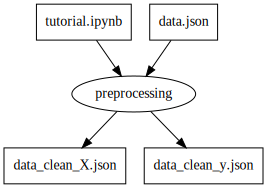

In [3]:
flor.Experiment('risecamp_demo').plot('first_preproc')

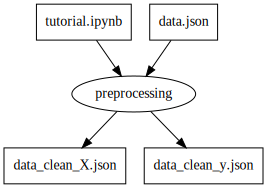

In [4]:
flor.Experiment('risecamp_demo').plot('second_preproc')

## Imports

In [ ]:
#General imports
import pandas as pd
import numpy as np
import nltk
import json
import time
import random
import scipy.sparse

#Pre-processing imports
from stop_words import get_stop_words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

#Model training and testing imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import average_precision_score, recall_score, precision_recall_fscore_support

In [ ]:
# If the notebook name has not already been set, you are able to set the name in code. 
flor.setNotebookName('tutorial.ipynb')

In [ ]:
%load_ext autoreload
%autoreload 2

## Preprocessing Data

Before building our model, we will define a pipeline to pre-process our text data. We have used the following techniques to pre-process the text reviews:
* Removal of Stop Words
* Stemming (reducing inflected words to their stem)
* Lemmatization (group together inflected forms of a words)


In [ ]:
# Run me
from florfunctions import preprocessing

## Train Test Split

We have created a function to split our data into train/test sets. Since we would like this to be a Flor Function, we must wrap it with the @flor.func decorator so it is able to be referenced by Flor actions. **Please navigate to the florfunctions.py file and wrap the `traintest_split` function with the Flor decorator.**

In [ ]:
# Run me
from florfunctions import traintest_split

## Model Training and Evaluation

Now, we can create a Flor function to train and evaluate a model to classify reviews into rating buckets. **Please navigate to the florfunctions.py file and complete the `train_test` function; fill in the Random Forest model with an n_estimators parameter of 5.**

In [ ]:
from florfunctions import train_test

## Experiment Setup

Finally, we will now define our Flor experiment using the Flor functions we created above. Proceed through the following cells and run the experiment.

In [ ]:
ex = flor.Experiment('risecamp_demo').__enter__()

Next, we need to load the data we want to analyze. We can load the data by creating **artifacts**, which are pointers to data we want. In this case, we have already generated cleaned data from a previous experiment run; we can retrieve the cleaned data by referencing the tag of the particular run.

In [ ]:
# Defines preprocessing action and resulting intermediary artifacts
data_x = ex.artifact('data_clean_X.json', 'intermediate_X', utag="first")
data_y = ex.artifact('data_clean_y.json', 'intermediate_y', utag="first")

Now that we have our data points, we need to perform a train/test split. Using the `traintest_split` function we imported earlier, let's create a flor action as well as the intermediary artifacts generated by the split.

In [ ]:
#traintest_split is the function to run, data_x and data_y are arguments
do_split = ex.action(traintest_split, [data_x, data_y])

In [ ]:
#artifacts have a pointer (filename), internal name, and (optional) parent
X_train = ex.artifact('x_train.npz', 'X_train', do_split)
X_test = ex.artifact('x_test.npz', 'X_test', do_split)
y_train = ex.artifact('y_train.json', 'y_train', do_split)
y_test = ex.artifact('y_test.json', 'y_test', do_split)

Lastly, we can specify the hyperparameter with a **literal**, an explicit value stored in Flor, and create an action for our `train_test` function and an artifact for our result. We can wrap up the experiment and close it with `__exit__()`.

In [ ]:
hyperparameter = ex.literal(v = 5, name="hyperparameters")
#Define the model training and evaluation action and final artifacts
do_test = ex.action(train_test, [X_train, X_test, y_train, y_test, hyperparameter])
report = ex.artifact('report.csv', 'report', do_test)
score = ex.literal(name='score', parent=do_test)

In [ ]:
ex.__exit__()

## Pull

Finally, we are ready to run the experiment! We can do so by running `pull()` on our output artifacts. Before doing this, however, it is helpful to use `plot()` to generate a florplan, a graph representation of the artifact's lineage.

In [ ]:
score.plot()

In [ ]:
#Run the experiment
score.pull('first_pull')

## Pull again, trying a different dataset

In [ ]:
with flor.Experiment('risecamp_demo') as ex:
    data_x = ex.artifact('data_clean_X.json', 'intermediate_X', utag="second")
    data_y = ex.artifact('data_clean_y.json', 'intermediate_y', utag="second")
    
    #traintest_split is the function to run, data_x and data_y are arguments
    do_split = ex.action(traintest_split, [data_x, data_y])
    
    #artifacts have a pointer (filename), internal name, and (optional) parent
    X_train = ex.artifact('x_train.npz', 'X_train', do_split)
    X_test = ex.artifact('x_test.npz', 'X_test', do_split)
    y_train = ex.artifact('y_train.json', 'y_train', do_split)
    y_test = ex.artifact('y_test.json', 'y_test', do_split)
    
    hyperparameter = ex.literal(v = 5, name="hyperparameters")
    #Define the model training and evaluation action and final artifacts
    do_test = ex.action(train_test, [X_train, X_test, y_train, y_test, hyperparameter])
    report = ex.artifact('report.csv', 'report', do_test)
    score = ex.literal(name='score', parent=do_test)


In [ ]:
score.plot()

In [ ]:
score.pull('second_pull')

## Compare the reports

In [ ]:
with flor.Experiment('risecamp_demo') as ex:
    report = ex.artifact('report.csv', 'report', utag='first_pull')
report.peek()

In [ ]:
with flor.Experiment('risecamp_demo') as ex:
    report = ex.artifact('report.csv', 'report', utag='second_pull')
report.peek()

## Compare the data: since it's the only thing that we changed

In [ ]:
with flor.Experiment('risecamp_demo') as ex:
    data_x1 = ex.artifact('data_clean_X.json', 'intermediate_X', utag="first")
    data_x2 = ex.artifact('data_clean_X.json', 'intermediate_X', utag="second")

In [ ]:
data_x1.peek()

In [ ]:
data_x2.peek()

## Hyperparameter Tuning

Flor makes it convenient to run models using different hyperparameters and track the results. In the `train_test` we created function, notice that we pass in `hyperparameters` in addition to the train and test data. These hyperparameters will allow us to tune our model and track results with ease; let's define them in our experiment setup.

Notice that the Random Forest Classifier contains `n_estimators` as a hyperparameter. We would like to tune this hyperparameter and track model performance. In order to specify the hyperparameters, we must make a `literalForEach` within our experiment. **Fill in the `literalForEach` with values 5, 50 and 75 within the experiment below.**

In [ ]:
#Note: We have copied the same experiment below for convenience.
#We can also create flor experiments using a context manager.

# Create a context manager for the experiment and is named 'risecamp_demo'
with flor.Experiment('risecamp_demo') as ex:

    # Defines artifacts
    data_x = ex.artifact('data_clean_X.json', 'intermediate_X', utag='second')
    data_y = ex.artifact('data_clean_y.json', 'intermediate_y', utag='second')

    #Define split action and resulting output artifacts
    do_split = ex.action(traintest_split, [data_x, data_y])
    X_train = ex.artifact('x_train.npz', 'X_train', do_split)
    X_test = ex.artifact('x_test.npz', 'X_test', do_split)
    y_train = ex.artifact('y_train.json', 'y_train', do_split)
    y_test = ex.artifact('y_test.json', 'y_test', do_split)

    #Define the hyperparameters for the models
    random_forest_Nestimators = ex.literal(v = 5, name="hyperparameters")
#     random_forest_Nestimators = ex.literalForEach(v=[5, 10, 15], name="hyperparameters", default=5) #SOLUTION

    #Define the model training and evaluation action and final artifacts
    do_test = ex.action(train_test, [X_train, X_test, y_train, y_test, random_forest_Nestimators])
    report = ex.artifact('report.csv', 'report', do_test)
    score = ex.literal(name='score', parent=do_test)


In [ ]:
score.plot()

In [ ]:
#Run the experiment
score.pull(utag="hyperparameter_tuning")

## Summarizing Results

After running the model with different hyperparameters above, we are able to peek at our output artifact, containing precision and recall metrics for the different models. Run the following cell - **which hyperparameter yields the best model?**

In [ ]:
import flor
flor.Experiment('risecamp_demo').summarize()

## Building a Better Model

Now that you have some experience using flor, let's try using a different model to see if we can improve the results. Some of the classifiers we recommend trying are the Multilayer Perceptron Classifier, Naive Bayes Classifier, and K-neighbors Classifier.

After implementing your model of choice in the `train_test` function in **florfunctions.py**, run the cells below to reimport the function and run the experiment.

In [ ]:
from florfunctions import train_test

In [ ]:
#Note: We have copied the same experiment below for convenience.
#We can also create flor experiments using a context manager.

# Create a context manager for the experiment and is named 'risecamp_demo'
with flor.Experiment('risecamp_demo') as ex:
    # Defines artifacts
    data_x = ex.artifact('data_clean_X.json', 'intermediate_X', utag='first')
    data_y = ex.artifact('data_clean_y.json', 'intermediate_y', utag='first')

    #Define split action and resulting output artifacts
    do_split = ex.action(traintest_split, [data_x, data_y])
    X_train = ex.artifact('x_train.npz', 'X_train', do_split)
    X_test = ex.artifact('x_test.npz', 'X_test', do_split)
    y_train = ex.artifact('y_train.json', 'y_train', do_split)
    y_test = ex.artifact('y_test.json', 'y_test', do_split)

    #Define the hyperparameters for the models
    #hyperparameter = ex.literal(v = 5, name="hyperparameters")
    random_forest_Nestimators = ex.literalForEach(v=[5, 10, 15], name="hyperparameters", default=5) #SOLUTION
    #MLP_hidden_layer_size = ex.literalForEach(v=[(1, ), (2, ), (3, )], name="hyperparameters", default=(2, ))

    #Define the model training and evaluation action and final artifacts
    #change to MLP_hidden_layer_size 
    do_test = ex.action(train_test, [X_train, X_test, y_train, y_test, random_forest_Nestimators])
    #for naive bayes
    #do_test = ex.action(train_test, [X_train, X_test, y_train, y_test])
    report = ex.artifact('report.csv', 'report', do_test)
    score = ex.literal(name='score', parent=do_test)


In [ ]:
score.plot()

In [ ]:
score.pull(utag="improved_model")

In [ ]:
flor.Experiment('risecamp_demo').summarize()

## Of all the things we tried, what helped the most?

In [ ]:
flor.Experiment('risecamp_demo').summarize().cube()